<a href="https://colab.research.google.com/github/itsPius256/Web-and-Social-Media-Analysis-Towards-Recommendations-for-Improving/blob/main/groupprojuct.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import json
from datetime import datetime
import pandas as pd
import re

# Load the dataset
file_path = "/content/drive/MyDrive/Dataupload/malaysiaairway.json"

# Reload the dataset
with open(file_path, "r", encoding="utf-8") as file:
    data = json.load(file)

# Extract relevant data again
combined_data = []

for post in data:
    post_url = post.get("url", "")
    timestamp =  datetime.strptime(post["timestamp"], "%Y-%m-%dT%H:%M:%S.%fZ").strftime("%Y-%m-%d %H:%M:%S")
    owner_full_name = post.get("ownerFullName", "")
    caption = post.get("caption", "")
    likes_count = post.get("likesCount", 0)
    video_view_count = post.get("videoViewCount", 0)
    video_play_count = post.get("videoPlayCount", 0)
    # Extract and format hashtags as a comma-separated string
    hashtags = ", ".join(post.get("hashtags", []))

    for comment in post.get("latestComments", []):
        comment_timestamp = comment.get("timestamp", "")
        comment_username = comment.get("ownerUsername", "")
        comment_text = comment.get("text", "")

        combined_data.append([
           post_url, timestamp, owner_full_name, caption, hashtags,
            likes_count, video_view_count, video_play_count,
            comment_timestamp, comment_username, comment_text
        ])

# Create a DataFrame with all data combined
df_combined = pd.DataFrame(combined_data, columns=[
   "Post URL", "Post Timestamp", "Owner Full Name", "Caption", "Hashtags",
    "Likes Count", "Video View Count", "Video Play Count",
    "Comment Timestamp", "Comment Username", "Comment Text"
])


# Define the CSV file path
excel_file_path = "/content/malaysiaairway_instagram_comments.xlsx"

# Export to Excel
df_combined.to_excel(excel_file_path, index=False)

print(f"Filtered data saved to: {excel_file_path}")


Filtered data saved to: /content/malaysiaairway_instagram_comments.xlsx


In [ ]:
!pip install vaderSentiment
!pip install langdetect

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 13.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993223 sha256=ea7d5790ef575c0decb791cdee4e6facdaa291acdfc9d32515545aa843e69eaa
  Stored in directory: /root/.cache/pip/wheels/0a/f2/b2/e5ca405801e05eb7c8ed5b3b4bcf1fcabcd6272c167640072e
Successfully built langdetect


In [ ]:
import pandas as pd
from langdetect import detect
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Load CSV file
df = pd.read_excel("/content/malaysiaairway_instagram_comments.xlsx")

# Convert 'Date' column to datetime format

# Convert to datetime format (if not already)
df["Post Timestamp"] = pd.to_datetime(df["Post Timestamp"])

# Convert to date only (removes time component)
df["Post Timestamp"] = df["Post Timestamp"].dt.date

# Define the date range (1st Sept 2024 to 28st Feb 2025)
start_date = datetime.strptime("2024-09-01", "%Y-%m-%d").date()
end_date = datetime.strptime("2025-02-28", "%Y-%m-%d").date()

# Filter rows within the date range
df = df[(df["Post Timestamp"] >= start_date) & (df["Post Timestamp"] <= end_date)]
df = df[df["Owner Full Name"] == "Malaysia Airlines"].copy()


# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to check if text is in English
def is_english(text):
    try:
        return detect(text) == "en"
    except:
        return False  # Handle errors for empty or non-text values

# Function to get sentiment score and classification
def get_sentiment(text):
    text = str(text)  # Ensure input is string
    sentiment_score = analyzer.polarity_scores(text)["compound"]  # VADER's compound score

    if sentiment_score >= 0.05:
        sentiment = "Positive"
    elif sentiment_score <= -0.05:
        sentiment = "Negative"
    else:
        sentiment = "Neutral"

    return sentiment_score, sentiment

# Filter English comments
df["is_english"] = df["Comment Text"].apply(is_english)
df_english = df[df["is_english"]].copy()  # Avoid SettingWithCopyWarning

# Apply sentiment analysis
df_english[["Sentiment_Score", "Sentiment"]] = df_english["Comment Text"].apply(lambda x: pd.Series(get_sentiment(x)))

# Save the filtered data
df_english.to_excel("english_comments_MalaysiaAirway_vader.xlsx")

print("Filtered English comments saved to english_comments_MalaysiaAirway_vader.xlsx")


Filtered English comments saved to english_comments_MalaysiaAirway_vader.xlsx


In [ ]:
pip install pandas networkx matplotlib

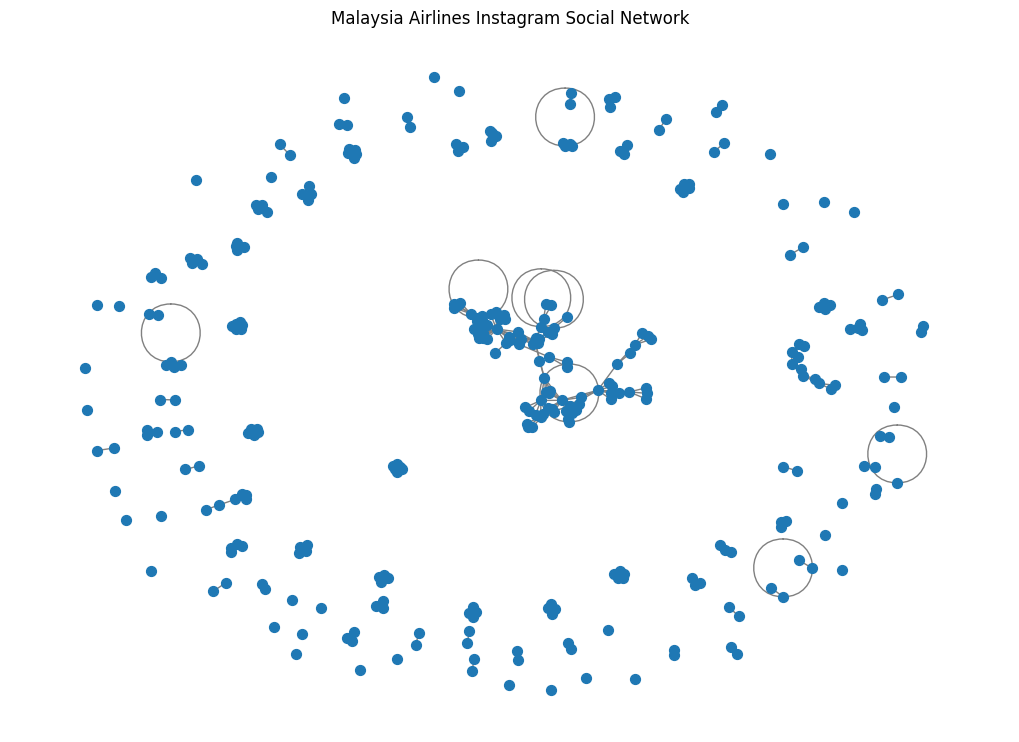

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Load cleaned data
df = pd.read_excel("english_comments_MalaysiaAirway_vader.xlsx")

# Create an empty graph
G = nx.Graph()

# Add nodes (users who commented)
for user in df["Comment Username"].unique():
    G.add_node(user)

# Add edges (connect users who commented on the same post)
for post_url in df["Post URL"].unique():
    commenters = df[df["Post URL"] == post_url]["Comment Username"].tolist()
    for i in range(len(commenters)):
        for j in range(i + 1, len(commenters)):
            G.add_edge(commenters[i], commenters[j])

# Draw the network
plt.figure(figsize=(10, 7))
nx.draw(G, with_labels=False, node_size=50, edge_color="gray")
plt.title("Malaysia Airlines Instagram Social Network")
plt.show()


In [ ]:
# Degree Centrality (Users with most connections)
degree_centrality = nx.degree_centrality(G)
top_degree_users = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]

# Betweenness Centrality (Users bridging different groups)
betweenness_centrality = nx.betweenness_centrality(G)
top_betweenness_users = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]

# Clustering Coefficient (User groups/clusters)
clustering_coeff = nx.clustering(G)
average_clustering = sum(clustering_coeff.values()) / len(clustering_coeff)

print("Top 10 Influential Users by Degree Centrality:", top_degree_users)
print("Top 10 Bridging Users by Betweenness Centrality:", top_betweenness_users)
print("Average Clustering Coefficient:", average_clustering)


Top 10 Influential Users by Degree Centrality: [('djouadi864', 0.0804953560371517), ('aneeljolly1', 0.052631578947368425), ('aniljolly1', 0.030959752321981428), ('orchid.love_', 0.027863777089783284), ('gtmluv', 0.027863777089783284), ('hartmut_erbel', 0.027863777089783284), ('proxima_sentauri_b', 0.027863777089783284), ('itsfizl', 0.02476780185758514), ('mitra.tourstravel', 0.021671826625386997), ('shanew72', 0.018575851393188854)]
Top 10 Bridging Users by Betweenness Centrality: [('djouadi864', 0.04641398893653571), ('gtmluv', 0.044189758283175964), ('aneeljolly1', 0.039468876795569485), ('mitra.tourstravel', 0.03784397054016114), ('aniljolly1', 0.02286406553468069), ('turnerhkg94', 0.008076457127473414), ('orchid.love_', 0.006615002980597273), ('proxima_sentauri_b', 0.006550904114506214), ('hartmut_erbel', 0.006538084341288002), ('itsfizl', 0.005047785704670884)]
Average Clustering Coefficient: 0.6019821429679818


In [ ]:
from networkx.algorithms import community

# Detect communities using the Girvan-Newman algorithm
communities = community.girvan_newman(G)
top_level_communities = next(communities)
sorted_communities = sorted(map(sorted, top_level_communities))

print("Detected Communities:", sorted_communities[:5])


Detected Communities: [['10_naoki_09', 'aqsajaved'], ['73ruok', 'leya.magpoc', 'ranee33s', 'sam_loke', 'theairlineandtravelshow', 'travisloh'], ['96shivi_', 'adammmrr69', 'piezhafiz', 'wanihazwanikarim'], ['___sanju.sahu', 'gurbaaz_rabnoor_my_life'], ['___wolf__of__dalal__street___', 'joseph.schober.3', 'juliannnn_04', 'madan_garima']]


In [ ]:
from networkx.algorithms import community

# Detect communities using the Girvan-Newman algorithm
communities = community.girvan_newman(G)
top_level_communities = next(communities)
sorted_communities = sorted(map(sorted, top_level_communities))

print("Detected Communities:", sorted_communities[:5])


Detected Communities: [['10_naoki_09', 'aqsajaved'], ['73ruok', 'leya.magpoc', 'ranee33s', 'sam_loke', 'theairlineandtravelshow', 'travisloh'], ['96shivi_', 'adammmrr69', 'piezhafiz', 'wanihazwanikarim'], ['___sanju.sahu', 'gurbaaz_rabnoor_my_life'], ['___wolf__of__dalal__street___', 'joseph.schober.3', 'juliannnn_04', 'madan_garima']]


ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


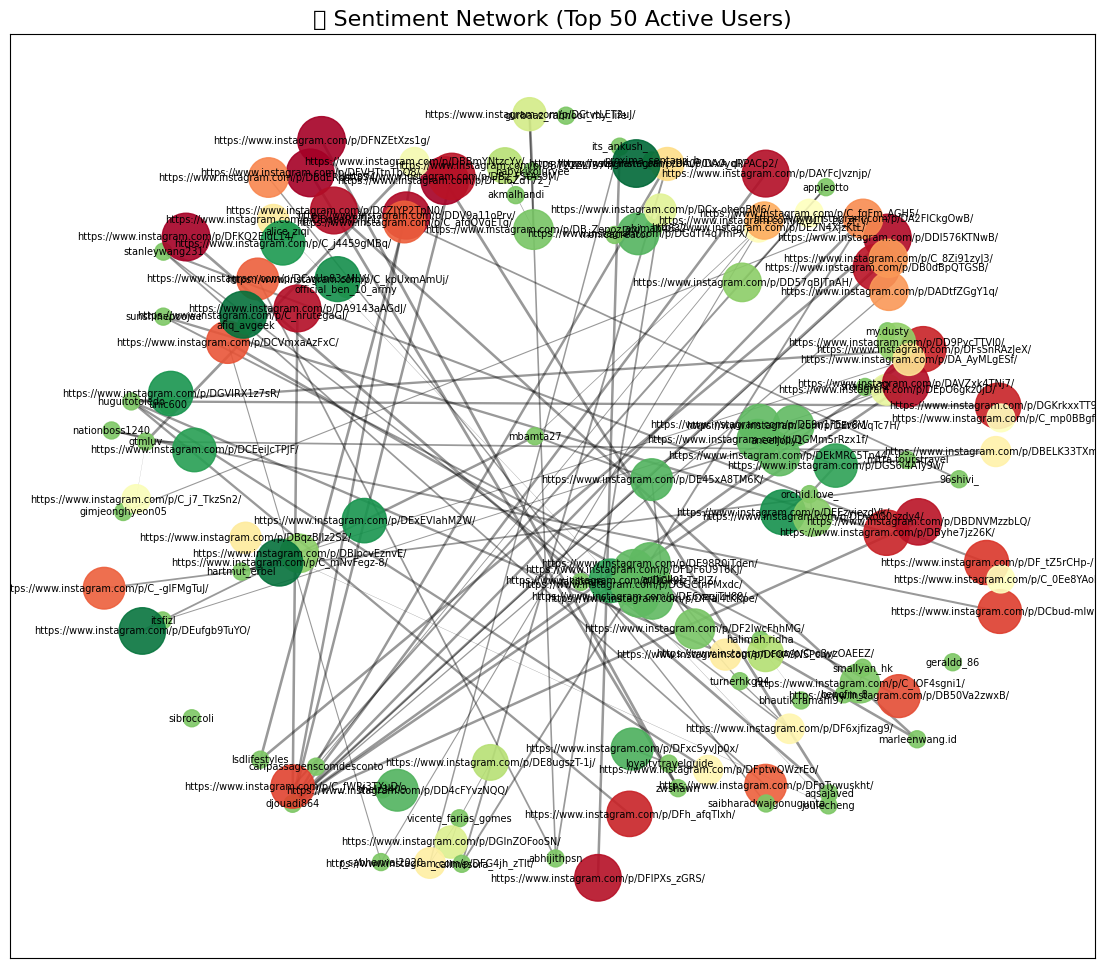

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Load dataset
df = pd.read_excel("/content/drive/MyDrive/Dataupload/english_comments_MalaysiaAirway_vader.xlsx")

# Filter needed columns
df = df[['Post URL', 'Comment Username', 'Sentiment_Score']].dropna()

# Create a graph
G = nx.Graph()

# Add edges with sentiment score as weight
for _, row in df.iterrows():
    post = row['Post URL']
    user = row['Comment Username']
    score = row['Sentiment_Score']
    G.add_node(post, type='post')
    G.add_node(user, type='user')
    G.add_edge(user, post, weight=score)

# Define colors and thickness
node_colors = []
node_sizes = []
for node in G.nodes:
    if G.nodes[node]['type'] == 'post':
        sentiments = [d['weight'] for u, v, d in G.edges(node, data=True)]
        avg_sentiment = np.mean(sentiments)
        node_colors.append(avg_sentiment)
        node_sizes.append(400 + 800 * abs(avg_sentiment))  # bigger = stronger emotion
    else:
        node_colors.append(0.5)  # neutral user color
        node_sizes.append(100)

# Draw graph
pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(14, 12))
edges = G.edges(data=True)
weights = [abs(d['weight']) for (_, _, d) in edges]

nx.draw_networkx_nodes(G, pos, node_color=node_colors, cmap=plt.cm.RdYlGn, node_size=node_sizes, alpha=0.9)
nx.draw_networkx_edges(G, pos, width=weights, alpha=0.4)
nx.draw_networkx_labels(G, pos, font_size=7)
plt.title('Sentiment Network (Node Color = Sentiment, Edge Thickness = Emotion Intensity)', fontsize=14)
plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.RdYlGn), label='Average Sentiment Score')
plt.axis('off')
plt.tight_layout()
plt.show()
